In [1]:
import albumentations as A
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

In [15]:
class_labels = ['c4', 'c2', 'b20', 'c12', 'a7']

data_path = os.path.join('data', 'znaki_wydrukowane')
images_path = os.path.join(data_path, 'train')
labels_path = os.path.join(data_path, 'labels')

images = os.listdir(images_path)

destination_data_path = os.path.join('data', 'new_augmented_data')
destination_images_path = os.path.join(destination_data_path, 'images')
destination_labels_path = os.path.join(destination_data_path, 'labels')

In [8]:
i = 0
num_images = 20

file_name, ext = images[30].split('.')

images_to_show = []
labels_to_show = []

while i < num_images:
    img = cv2.imread(os.path.join(images_path, f'{file_name}.{ext}'))
    max_crop_size = np.min(img.shape[:2])
    if max_crop_size > 320:
        random_size = np.random.randint(320, max_crop_size)
    else:
        random_size = max_crop_size

    transform = A.Compose([
        A.RandomCrop(p=1, width=random_size, height=random_size),
        A.RGBShift(p=0.5), 
        A.RandomGamma(p=0.5), 
        A.RandomBrightnessContrast(p=0.5),
    ], bbox_params=A.BboxParams(format='yolo', min_visibility=0.3))

    bboxes = []

    with open(os.path.join(labels_path, f'{file_name}.txt')) as file:
        for line in file.readlines():
            class_idx, x, y, w, h = list(map(lambda x: float(x), line.split(' ')))
            bbox = [x, y, w, h, class_labels[int(class_idx)]]
            bboxes.append(bbox)

    transformed = transform(image=img, bboxes=bboxes)
    height, width, _ = transformed['image'].shape

    temp_labels = []

    bboxes_to_save = []

    if len(transformed['bboxes']) != 0:
        cv2.imwrite(os.path.join(destination_images_path, f"{file_name}_{i}.{ext}"), transformed['image'])
        
        for bbox in transformed['bboxes']:
            cv2.rectangle(transformed['image'], 
                tuple(np.multiply(np.subtract(bbox[:2], np.divide(bbox[2:4], 2)), [width, height]).astype(int)),
                tuple(np.multiply(np.add(bbox[:2], np.divide(bbox[2:4], 2)), [width, height]).astype(int)),
                (255,0,0), 2)
            
            x, y, w, h, class_name = bbox
            idx = class_labels.index(class_name)

            temp_labels.append(class_name)
            bboxes_to_save.append(" ".join(map(lambda x: str(x), [idx, x, y, w, h]))+'\n')

        images_to_show.append(transformed['image'])
        with open(os.path.join(destination_labels_path, f"{file_name}_{i}.txt"), 'w+') as f:
            f.writelines(bboxes_to_save)
        
        label = " ".join(temp_labels)
        labels_to_show.append(label)

        i += 1

In [10]:
len(images_to_show)

20

In [12]:
def show_images(images, cols=0, rows=1, labels=[], figsize=(10, 7)):
    def get_element(elements):
        for e in elements:
            yield e

    if not cols:
        cols =int(np.ceil(len(images)/rows))

    count = 0

    image_gen = get_element(images)

    if len(labels):
        label_gen = get_element(labels)
    
    fig = plt.figure(figsize=figsize)

    for _ in range(rows):
        for _ in range(cols):
            count += 1

            if count >len(images): return 
            fig.add_subplot(rows, cols, count)

            img = next(image_gen)
            plt.imshow(img)
            plt.axis('off')

            if len(labels):
                plt.title(next(label_gen))

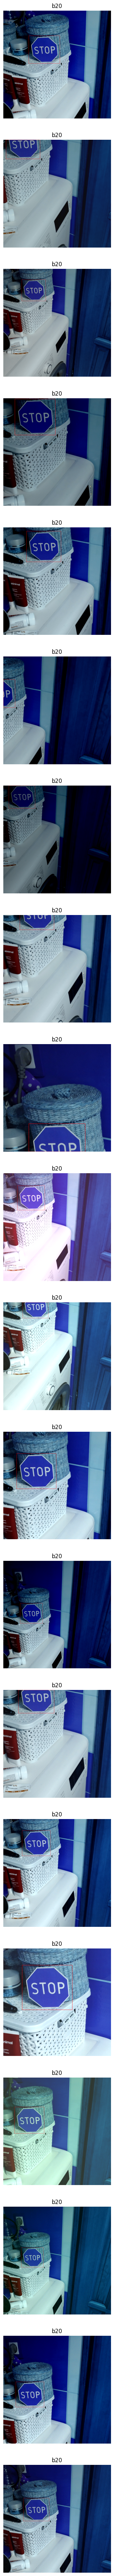

In [13]:
show_images(images_to_show, labels=labels_to_show, cols=1, rows=20, figsize=(100, 100))

In [16]:
for image in images:
    i = 0
    num_images = 10

    split_idx = image.rindex('.')

    file_name = image[:split_idx]
    ext = image[split_idx+1:]

    img = cv2.imread(os.path.join(images_path ,f'{file_name}.{ext}'))
    max_crop_size = np.min(img.shape[:2])

    for i in range(10):
        if max_crop_size > 320:
            random_size = np.random.randint(320, max_crop_size)
        else:
            random_size = max_crop_size

        transform = A.Compose([
            A.RandomCrop(p=1, width=random_size, height=random_size),
            A.RGBShift(p=0.5), 
            A.RandomGamma(p=0.5), 
            A.RandomBrightnessContrast(p=0.5),
        ], bbox_params=A.BboxParams(format='yolo', min_visibility=0.3))

        bboxes = []

        with open(os.path.join(labels_path, f'{file_name}.txt')) as file:
            for line in file.readlines():
                class_idx, x, y, w, h = list(map(lambda x: float(x), line.split(' ')))
                bbox = [x, y, w, h, class_labels[int(class_idx)]]
                bboxes.append(bbox)

        transformed = transform(image=img, bboxes=bboxes)
        bboxes_to_save = []

        if len(transformed['bboxes']) != 0:
            cv2.imwrite(os.path.join(destination_images_path, f"{file_name}_{i}.{ext}"), transformed['image'])
            
            for bbox in transformed['bboxes']:
                x, y, w, h, class_name = bbox
                idx = class_labels.index(class_name)

                bboxes_to_save.append(" ".join(map(lambda x: str(x), [idx, x, y, w, h]))+'\n')
            
            with open(os.path.join(destination_labels_path, f"{file_name}_{i}.txt"), 'w+') as f:
                f.writelines(bboxes_to_save)